Abstract

This project aims to help an e-commerce company identify its high‐value (“VIP”) customers who are at risk of churning — i.e., stopping purchases. The project has two main tasks:

Predict the Customer Lifetime Value (CLV) for the next 6 months using features like purchase frequency, average order value, and customer tenure (Regression).

Use the predicted CLV together with behavioural features (e.g., days since last purchase, service calls, items left in cart) to predict whether the customer will churn in the next 3 months (Classification).
The output will enable the marketing team to target VIP customers proactively to reduce churn and improve lifetime revenue.



Introduction / Problem Statement

Business context: For an e-commerce company, retaining high-value customers is more cost-effective than acquiring new ones. Losing a VIP customer means a large revenue loss.

Problem statement: We need to identify which VIP customers are at high risk of churning (ceasing purchases) so that they can be targeted for retention.

Objectives:

Task 1: Build a model to predict CLV (continuous) for next 6 months.

Task 2: Build a model to classify whether a customer will churn in next 3 months (yes/no).

Scope & benefits: Focus on VIP segment of customers (top X% by past spend). The benefit: reduce churn, increase retention, forecast revenue from those at risk.

In [323]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [324]:
df = pd.read_excel('/content/Online Retail.xlsx')

In [325]:
df.to_csv('/content/Online Retail.xlsx',index = False)

In [326]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [327]:
#Handle Missing Data: Drop all rows where CustomerID is null. You can't track a customer if you don't know who they are.

df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [328]:
df = df.drop(columns = 'Description')

In [329]:
df = df.dropna()

In [330]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [331]:
df.shape

(406829, 7)

In [332]:
#Handle Cancellations: Filter out (or handle) transactions where the Quantity is negative, as these are returns or cancellations.
df = df[df['Quantity'] > 0].copy()



In [333]:
df.shape

(397924, 7)

In [334]:
#Create TotalPrice: This is your most important column. df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [335]:
#Convert InvoiceDate: Make sure this column is in the datetime format.

In [336]:
df['Time'] = df['InvoiceDate'].dt.time
df['Date'] = df['InvoiceDate'].dt.date

In [337]:
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Time,Date
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,08:26:00,2010-12-01
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,08:26:00,2010-12-01
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,08:26:00,2010-12-01
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,08:26:00,2010-12-01
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,08:26:00,2010-12-01


Data for Features: You will use all data before this date (Sept 1, 2011) to build your features.

Data for Targets: You will use all data after this date (Sept 1, 2011 - Dec 2011) to see what the customers actually did.

In [338]:
snapshot = '2011-09-01'

Training = df[df['InvoiceDate'] < snapshot].copy()


In [339]:
Testing = df[df['InvoiceDate'] >= snapshot].copy()


In [340]:
Training.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Time,Date
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,08:26:00,2010-12-01
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,08:26:00,2010-12-01
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,08:26:00,2010-12-01
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,08:26:00,2010-12-01
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,08:26:00,2010-12-01


In [341]:
Testing.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Time,Date
320705,565080,20677,8,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,10.0,08:25:00,2011-09-01
320706,565080,22128,24,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,30.0,08:25:00,2011-09-01
320708,565082,22423,2,2011-09-01 09:15:00,12.75,13305.0,United Kingdom,25.5,09:15:00,2011-09-01
320709,565082,15060B,8,2011-09-01 09:15:00,3.75,13305.0,United Kingdom,30.0,09:15:00,2011-09-01
320710,565082,23245,4,2011-09-01 09:15:00,4.95,13305.0,United Kingdom,19.8,09:15:00,2011-09-01


For each CustomerID, you will calculate their RFM features based on their activity before the snapshot date:

Recency (R): How many days ago was their last purchase (before Sept 1)? (e.g., Snapshot_Date - Last_Purchase_Date)

Frequency (F): How many total transactions (invoices) have they made?

Monetary (M): What is the total sum of TotalPrice they have spent?

You will now have a new DataFrame, with one row per customer, and columns for CustomerID, Recency, Frequency, and Monetary.

In [342]:
snapshot_date = pd.Timestamp('2011-09-01')
Training = Training.groupby('CustomerID').agg(
    Recency = ('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
    Frequency = ('InvoiceNo', 'nunique'),
    Monetary = ('TotalPrice', 'sum')
).reset_index()


Target 1 (Regression): CLV_3_Month → Total money spent by each customer between Sept 1, 2011 and Dec 1, 2011

Target 2 (Classification): is_churned → Whether the customer made no purchase in that 3-month window (1 = churned, 0 = active)

In [343]:
# Target column for regression
end_date      = pd.Timestamp('2011-12-01')

df_window = df[(df['InvoiceDate'] >= snapshot_date) & (df['InvoiceDate'] < end_date)].copy()

clv = df_window.groupby('CustomerID').agg(
    CLV_3_Month = ('TotalPrice', 'sum')
).reset_index()

Training = Training.merge(clv, on='CustomerID', how='left')

Training['CLV_3_Month'] = Training['CLV_3_Month'].fillna(0.0)


In [344]:
Training.head()

,CustomerID,Recency,Frequency,Monetary,CLV_3_Month
0,12346.0,225,1,77183.60,0.00
1,12347.0,29,5,2790.86,1294.32
2,12348.0,148,3,1487.24,310.00
3,12350.0,210,1,334.40,0.00
4,12352.0,162,5,1561.81,944.23


In [345]:
# Target column for classification

target = df_window.groupby('CustomerID').agg(
    Total_Purchases_After = ('InvoiceNo', 'nunique')
).reset_index()

target['is_churned'] = np.where(target['Total_Purchases_After'] == 0, 1, 0)
Training = Training.merge(target[['CustomerID','is_churned']], on='CustomerID', how='left')

Training['is_churned'] = Training['is_churned'].fillna(1).astype(int)


In [346]:
Training.head()

,CustomerID,Recency,Frequency,Monetary,CLV_3_Month,is_churned
0,12346.0,225,1,77183.60,0.00,1
1,12347.0,29,5,2790.86,1294.32,0
2,12348.0,148,3,1487.24,310.00,0
3,12350.0,210,1,334.40,0.00,1
4,12352.0,162,5,1561.81,944.23,0


We have our complete, final dataset: [CustomerID, Recency, Frequency, Monetary, CLV_3_Month, is_churned]

In [347]:
#Regression

In [348]:
Training.columns

Index(['CustomerID', 'Recency', 'Frequency', 'Monetary', 'CLV_3_Month',
       'is_churned'],
      dtype='object')

In [349]:
X = Training[['Recency', 'Frequency', 'Monetary']]
y = Training['CLV_3_Month']

<Axes: >

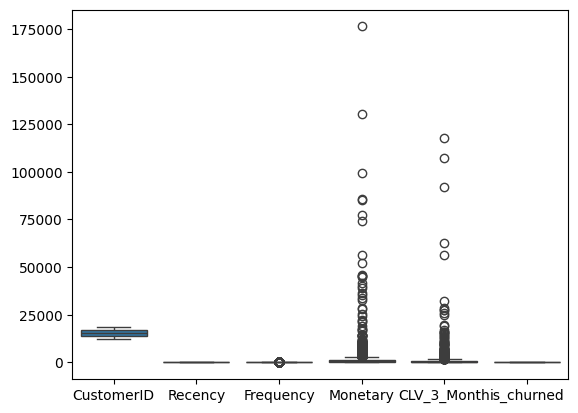

In [350]:
import seaborn as sns

sns.boxplot(Training)

In [351]:
#IQR

Q1 = Training.quantile(0.25)
Q3 = Training.quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

Training['Monetary'] = Training['Monetary'].clip(lower = lower['Monetary'],upper = upper['Monetary'])
Training['CLV_3_Month'] = Training['CLV_3_Month'].clip(lower = lower['CLV_3_Month'],upper = upper['CLV_3_Month'])


<Axes: >

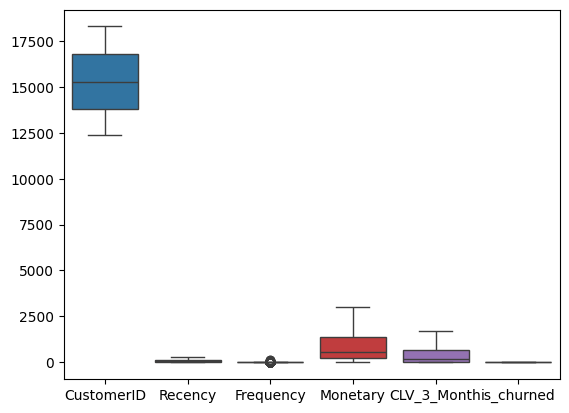

In [352]:
sns.boxplot(Training)

In [353]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import xgboost as xgb

std_x = StandardScaler()
X_std = std_x.fit_transform(X)



poly = PolynomialFeatures(degree = 2)
X_poly = poly.fit_transform(X_std)

x_train,x_test,y_train,y_test = train_test_split(X_poly,y,test_size = 0.2,random_state = 42)

model = LinearRegression()
model.fit(x_train,y_train)

y_pred= model.predict(x_test)

print('mse',mean_squared_error(y_test,y_pred))
print('mae',mean_absolute_error(y_test,y_pred))
print('r2',r2_score(y_test,y_pred))


mse 15311566.166747592
mae 755.9509219990845
r2 0.6252968900663768


In [354]:
Predicted_CLV = model.predict(X_poly)

In [355]:
Training['Predicted_CLV'] = Predicted_CLV

In [356]:
Training.head(10)

,CustomerID,Recency,Frequency,Monetary,CLV_3_Month,is_churned,Predicted_CLV
0,12346.0,225,1,2995.735,0.00,1,14298.798212
1,12347.0,29,5,2790.860,1294.32,0,1100.947701
2,12348.0,148,3,1487.240,310.00,0,431.556120
3,12350.0,210,1,334.400,0.00,1,163.368937
4,12352.0,162,5,1561.810,944.23,0,432.001516
5,12353.0,104,1,89.000,0.00,1,218.828229
6,12354.0,132,1,1079.400,0.00,1,382.768885
7,12355.0,114,1,459.400,0.00,1,284.016560
8,12356.0,145,2,2753.080,58.35,0,694.401609
9,12358.0,50,1,484.860,0.00,1,438.348363


In [357]:
Training.columns

Index(['CustomerID', 'Recency', 'Frequency', 'Monetary', 'CLV_3_Month',
       'is_churned', 'Predicted_CLV'],
      dtype='object')

In [358]:
#Classification

In [359]:
X_C = Training[['Recency', 'Frequency', 'Monetary','Predicted_CLV']]
y_c  = Training['is_churned']

In [360]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics         import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)


std_xc = StandardScaler()
X_std = std_xc.fit_transform(X_C)

x_train,x_test,y_train,y_test = train_test_split(X_std,y_c,test_size = 0.2,random_state = 42)

model_ = LogisticRegression()
model_.fit(x_train,y_train)

y_pred = model_.predict(x_test)

print("Accuracy     :", accuracy_score(y_test,       y_pred))
print("Precision    :", precision_score(y_test,      y_pred))
print("Recall       :", recall_score(y_test,         y_pred))
print("F1 Score     :", f1_score(y_test,             y_pred))
print("ROC AUC      :", roc_auc_score(y_test,      y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Accuracy     : 0.6762048192771084
Precision    : 0.6121794871794872
Recall       : 0.6701754385964912
F1 Score     : 0.6398659966499163
ROC AUC      : 0.6754571124380873
Confusion Matrix:
 [[258 121]
 [ 94 191]]


In [361]:
import joblib
from google.colab import files

# --- 1. Save all your files ---
print("Saving files to Colab...")

# Make sure these variable names match your code!
# (std_x, poly, model, classification_model)

# 1. The X scaler for the regression model
joblib.dump(std_x, 'x_scaler.pkl')

# 2. The PolynomialFeatures transformer
joblib.dump(poly, 'poly_features.pkl')

# 3. The regression model itself
joblib.dump(model, 'regression_model.pkl')

# 4. The final classification model
joblib.dump(model_, 'classification_model.pkl')

print("All 4 files saved.")

# --- 2. Download the files to your computer ---
print("Downloading files...")
files.download('x_scaler.pkl')
files.download('poly_features.pkl')
files.download('regression_model.pkl')
files.download('classification_model.pkl')

print("All files downloaded!")

Saving files to Colab...
All 4 files saved.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All files downloaded!
